In [1]:
import numpy as np
import pandas as pd
from statsbombpy import sb
import networkx as nx

In [6]:
competition_df = sb.competitions()
season = competition_df[ (competition_df.competition_name == 'La Liga') & (competition_df.season_name == '2020/2021') ]

C:\Users\Lawrence\AppData\Local\Programs\Python\Python39\lib\site-packages\statsbombpy\api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
19,11,90,Spain,La Liga,male,False,False,2020/2021,2022-02-11T14:56:09.076,2021-10-30T04:19:36.116600,2021-09-17T15:18:33.787790,2022-02-11T14:56:09.076


In [40]:
season_matches = sb.matches(competition_id = season.competition_id.iloc[0],season_id = season.season_id.iloc[0])
barcelona_matches = season_matches[ (season_matches.home_team == 'Barcelona') | ( season_matches.away_team == 'Barcelona') ]
#Note that matches are not in date order

C:\Users\Lawrence\AppData\Local\Programs\Python\Python39\lib\site-packages\statsbombpy\api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


In [80]:
season_barcelona_passes = pd.DataFrame()
#Currently doing just 10 matches as it takes a long time
for match_id_iter in barcelona_matches.match_id[0:10]:
    match_iter = sb.events(match_id=match_id_iter)
    match_iter = match_iter[(match_iter.type == 'Pass') & (match_iter.team == 'Barcelona')]
    season_barcelona_passes = pd.concat([season_barcelona_passes, match_iter[['player','pass_recipient','pass_length']]], ignore_index=True)
season_barcelona_passes

C:\Users\Lawrence\AppData\Local\Programs\Python\Python39\lib\site-packages\statsbombpy\api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


,player,pass_recipient,pass_length
0,Lionel Andrés Messi Cuccittini,Ousmane Dembélé,2.765863
1,Ousmane Dembélé,Sergio Busquets i Burgos,13.368994
2,Sergio Busquets i Burgos,Sergino Dest,25.373411
3,Sergino Dest,Óscar Mingueza García,15.530937
4,Óscar Mingueza García,Frenkie de Jong,19.638992
...,...,...,...
7817,Francisco António Machado Mota de Castro Trincão,NaN,1.513275
7818,Francisco António Machado Mota de Castro Trincão,Sergi Roberto Carnicer,10.607545
7819,Sergi Roberto Carnicer,Francisco António Machado Mota de Castro Trincão,19.964218
7820,Francisco António Machado Mota de Castro Trincão,Sergino Dest,21.095022


In [121]:
unique_pass_combinations = season_barcelona_passes.groupby(['player','pass_recipient']).size().reset_index().rename(columns={0:'count'})
unique_pass_combinations['weight'] = np.nan

for i,row in unique_pass_combinations.iterrows():
    unique_pass_combinations.weight[i] = season_barcelona_passes[(season_barcelona_passes.player == row.player) & (season_barcelona_passes.pass_recipient == row.pass_recipient)].pass_length.sum()
unique_pass_combinations['weight'] = unique_pass_combinations['weight'] / unique_pass_combinations['weight'].max()

C:\Users\Lawrence\AppData\Local\Temp/ipykernel_26052/3982459060.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_pass_combinations.weight[i] = season_barcelona_passes[(season_barcelona_passes.player == row.player) & (season_barcelona_passes.pass_recipient == row.pass_recipient)].pass_length.sum()


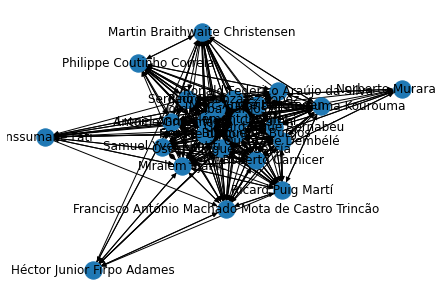

In [122]:
G = nx.from_pandas_edgelist(unique_pass_combinations,'player','pass_recipient',edge_attr='weight',create_using=nx.DiGraph())
nx.draw(G,with_labels=True)

In [127]:
player_centrality = pd.DataFrame(G.nodes()).rename(columns={0:'player'})
player_centrality['degree'] = pd.Series(nx.degree_centrality(G)).values
player_centrality['in_degree'] = pd.Series(nx.in_degree_centrality(G)).values
player_centrality['out_degree'] = pd.Series(nx.out_degree_centrality(G)).values
player_centrality['closeness'] = pd.Series(nx.closeness_centrality(G)).values
player_centrality

,player,degree,in_degree,out_degree,closeness
0,Anssumane Fati,0.869565,0.434783,0.434783,0.638889
1,Antoine Griezmann,1.869565,0.956522,0.913043,0.958333
2,Francisco António Machado Mota de Castro Trincão,1.521739,0.869565,0.652174,0.884615
3,Frenkie de Jong,1.869565,0.956522,0.913043,0.958333
4,Gerard Piqué Bernabéu,1.695652,0.869565,0.826087,0.884615
5,Jordi Alba Ramos,1.826087,0.869565,0.956522,0.884615
6,Lionel Andrés Messi Cuccittini,1.826087,0.913043,0.913043,0.920000
7,Miralem Pjanić,1.782609,0.826087,0.956522,0.851852
8,Pedro González López,1.739130,0.869565,0.869565,0.884615
9,Sergi Roberto Carnicer,1.826087,0.913043,0.913043,0.920000


In [147]:
#Sourced from:
#https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

In [148]:
weighted_degrees = dict(nx.degree(G, weight='Weight'))
nx.set_node_attributes(G, name='weighted_degree', values=weighted_degrees)

{'Anssumane Fati': 20,
 'Antoine Griezmann': 43,
 'Francisco António Machado Mota de Castro Trincão': 35,
 'Frenkie de Jong': 43,
 'Gerard Piqué Bernabéu': 39,
 'Jordi Alba Ramos': 42,
 'Lionel Andrés Messi Cuccittini': 42,
 'Miralem Pjanić': 41,
 'Pedro González López': 40,
 'Sergi Roberto Carnicer': 42,
 'Sergio Busquets i Burgos': 44,
 'Clément Lenglet': 38,
 'Héctor Junior Firpo Adames': 12,
 'Marc-André ter Stegen': 36,
 'Martin Braithwaite Christensen': 31,
 'Moriba Kourouma Kourouma': 35,
 'Ousmane Dembélé': 36,
 'Philippe Coutinho Correia': 27,
 'Ronald Federico Araújo da Silva': 36,
 'Samuel Yves Umtiti': 29,
 'Sergino Dest': 41,
 'Óscar Mingueza García': 42,
 'Ricard Puig Martí': 31,
 'Norberto Murara Neto': 11}

In [151]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'weighted_degree'
color_by_this_attribute = 'weighted_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Barcelona Pass Graph'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Player", "@index"),
        ("Weighted Degree", "@weighted_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")